## Import dependencies

In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
sys.path.append('..')
from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import signal
from scipy.io.idl import readsav
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import requests
import ftplib
import io
import cmocean
from bs4 import BeautifulSoup
import urllib.request
from io import StringIO, BytesIO
from zipfile import ZipFile
import tqdm
import seaborn as sn
import re

## get SSP emissions
from tools.RCMIP import *

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
    
## Pandas options setup

pd.set_option('display.max_columns', 100)
    
## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
# matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

%load_ext line_profiler
%load_ext memory_profiler

/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
../tools/RCMIP.py:61: PerformanceWarning: indexing past lexsort depth may impact performance.
  GIR_to_RCMIP_map.loc[RCMIP_to_GIR_map_concs.values(),'RCMIP_concs_unit'] = RCMIP_concs.loc[('World','ssp245')].reindex(RCMIP_to_GIR_map_concs.keys()).loc[:,'Unit'].values#.loc[('World','ssp245',RCMIP_to_GIR_map_concs.keys()),'Unit'].values


## Contents:
- SSP inverse emissions (CO2 CH4 N2O)
- SSP concentrations (CO2 CH4 N2O)
- SSP forcings
- SSP temperature plumes
- Comparison of C4MIP / FaIR carbon cycle feedback parameters?

### Supplementary figures
- comparison of the FaIR and GIR carbon cycle
- Etminan comparison (OLBL vs Etminan formulae)
- comparing the CH4 lifetime computation with Holmes
- 1pctCO2 / abrupt4xCO2, compare to CMIP6
- compare SSPs to CMIP6?

# NROY Ensemble Generation

## Part I: the Global Warming Index

In [2]:
## Import data
baseline = ['1861','1880']

url = "https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/time_series/HadCRUT.4.6.0.0.monthly_ns_avg.txt"
req = requests.get(url, headers=header)
data = StringIO(req.text)
HadCRUT4 = pd.read_csv(data,delim_whitespace=True,index_col=0,names=['date','anom','lower_bias','upper_bias','lower_measure','upper_measure','lower_cover','upper_cover','lower_bias_measure','upper_bias_measure','lower_full','upper_full']).apply(pd.to_numeric)
HadCRUT4.index = pd.to_datetime(['-'.join(x.split('/'))+'-01' for x in HadCRUT4.index])
HadCRUT4 = HadCRUT4['anom'].rename('HadCRUT4')

GISS = pd.read_csv("https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.txt",skiprows=7,skipfooter=7,delim_whitespace=True,index_col=0).iloc[:,:12]
GISS = GISS.loc[GISS.index!='Year'].replace('****',np.nan).apply(pd.to_numeric)/100
month_map = dict(zip(GISS.columns,["{:02d}".format(x) for x in np.arange(1,13)]))
GISS = pd.DataFrame(GISS.values.flatten(),index = pd.to_datetime([x+'-'+month_map[y]+'-01' for x in GISS.index for y in GISS.columns]),columns=['anom'])
GISS = GISS['anom'].rename('GISTEMP')

CW_Had4_krig = pd.read_csv("https://www-users.york.ac.uk/~kdc3/papers/coverage2013/had4_krig_v2_0_0.txt",delim_whitespace=True,index_col=0,names=['date','anom','unc_full','unc_cover','unc_ens']).apply(pd.to_numeric)
CW_Had4_krig.index = pd.to_datetime([str(int(x//1))+'-'+"{:02d}".format(int((x % 1)*12)+1)+'-01' for x in CW_Had4_krig.index])
CW_Had4_krig = CW_Had4_krig['anom'].rename('CW')

Berkeley = pd.read_csv("http://berkeleyearth.lbl.gov/auto/Global/Land_and_Ocean_complete.txt",skiprows=76,delim_whitespace=True,usecols=[0,1,2,3],names=['date','month','anom','unc_full'])
Berkeley = Berkeley.iloc[:Berkeley.loc[Berkeley.date=='%'].index.min()].apply(pd.to_numeric)
Berkeley.index = pd.to_datetime(Berkeley.date.astype(str) + Berkeley.month.astype(str),format='%Y%m')
Berkeley = Berkeley['anom'].rename('Berkeley')

parser = 'html.parser'  # or 'lxml' (preferred) or 'html5lib', if installed
resp = urllib.request.urlopen("https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/")
soup = BeautifulSoup(resp, parser, from_encoding=resp.info().get_param('charset'))
NOAA_fname = [x['href'] for x in soup.find_all('a', href=True) if x['href'].split('.')[1:5]==['mon','land_ocean','90S','90N']][0]
NOAA = pd.read_csv("https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/"+NOAA_fname,delim_whitespace=True,names=['date','month','anom','unc_full'],usecols=[0,1,2,3]).apply(pd.to_numeric)
NOAA.index = pd.to_datetime(NOAA.date.astype(str) + NOAA.month.astype(str),format='%Y%m')
NOAA = NOAA['anom'].rename('NOAA')

## Combine into a single df

GMST_datasets = pd.concat([HadCRUT4,CW_Had4_krig,GISS,NOAA,Berkeley],axis=1)

## Baseline to 1861:1880 OR to HadCRUT4 20C mean if data begins in 1880 (GISTEMP / NOAA)

GMST_datasets.loc[:,['HadCRUT4','CW','Berkeley']] -= GMST_datasets.loc[baseline[0]:baseline[1],['HadCRUT4','CW','Berkeley']].mean()
GMST_datasets.loc[:,['GISTEMP','NOAA']] -= GMST_datasets.loc['1900':'2000',['GISTEMP','NOAA']].mean() -  GMST_datasets.loc['1900':'2000','HadCRUT4'].mean()

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


<AxesSubplot:>

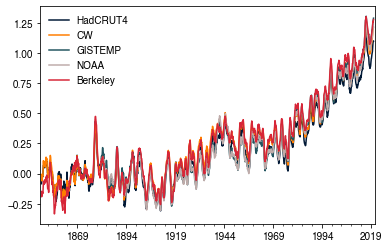

In [3]:
GMST_datasets.rolling(12).mean().plot()

In [4]:
## Import the observational uncertainty from HadCRUT

HadCRUT_ensmem_zip = ZipFile(BytesIO(requests.get('https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/time_series/HadCRUT.4.6.0.0.annual_ns_avg_realisations.zip').content))
HadCRUT_ensmem_fnames = [x.filename for x in HadCRUT_ensmem_zip.infolist() if x.filename[-4:] == '.txt']
HadCRUT_ensmem_index = pd.read_csv(HadCRUT_ensmem_zip.open(HadCRUT_ensmem_fnames[0]),header=None,delim_whitespace=True,usecols=[0],index_col=0).index
# HadCRUT_ensmem_index = pd.to_datetime(['-'.join(x.split('/'))+'-01' for x in HadCRUT_ensmem_index])
HadCRUT_ensmem = pd.concat([pd.read_csv(HadCRUT_ensmem_zip.open(x),header=None,delim_whitespace=True,usecols=[1]).iloc[:,0].rename(str(i)) for i,x in enumerate(HadCRUT_ensmem_fnames)],axis=1)
HadCRUT_ensmem.index = HadCRUT_ensmem_index

In [5]:
## import forcing ensemble: for now, use the most up-to-date copy I have (.idlsave)

# forcing_dataset = readsav('/home/leachl/Documents/Datasets/RF/1750_Oct2017_forcings.idlsave')
# rf_ant = pd.DataFrame(forcing_dataset['rf_anthro'].byteswap().newbyteorder(),index = pd.to_datetime([str(int(x))+'-01-01' for x in forcing_dataset['year']])).apply(pd.to_numeric)
# rf_nat = pd.DataFrame(forcing_dataset['rf_nat'].byteswap().newbyteorder(),index = pd.to_datetime([str(int(x))+'-01-01' for x in forcing_dataset['year']])).apply(pd.to_numeric)

In [6]:
## creating a forcing response dataset

erf_ar6 = pd.read_csv('https://raw.githubusercontent.com/Priestley-Centre/ssp_erf/master/SSPs/ERF_ssp245_1750-2500.csv',index_col=0,dtype=float)
erf_ar6 -= erf_ar6.loc[1750]

aer_ar6 = pd.read_csv('../tmp/aerosol_forcing.csv',index_col=0)

In [7]:
## generating many rf shapes for the GWI

N = 10000

rf_factors = {}

rf_factors['co2'] = sp.stats.norm(1,0.20/1.645).rvs(N)#ppf((erf_ar6.mean()>0).co2*random_percentiles + ~(erf_ar6.mean()>0).co2*(1-random_percentiles))
rf_factors['ch4'] = sp.stats.norm(1,0.28/1.645).rvs(N)#ppf((erf_ar6.mean()>0).ch4*random_percentiles + ~(erf_ar6.mean()>0).ch4*(1-random_percentiles))
rf_factors['n2o'] = sp.stats.norm(1,0.2/1.645).rvs(N)#ppf((erf_ar6.mean()>0).n2o*random_percentiles + ~(erf_ar6.mean()>0).n2o*(1-random_percentiles))
rf_factors['other_wmghg'] = sp.stats.norm(1,0.20/1.645).rvs(N)#ppf((erf_ar6.mean()>0).other_wmghg*random_percentiles + ~(erf_ar6.mean()>0).other_wmghg*(1-random_percentiles))
rf_factors['o3_tropospheric'] = sp.stats.norm(1,0.5/1.645).rvs(N)#ppf((erf_ar6.mean()>0).o3_tropospheric*random_percentiles + ~(erf_ar6.mean()>0).o3_tropospheric*(1-random_percentiles))
rf_factors['o3_stratospheric'] = sp.stats.norm(1,2/1.645).rvs(N)#ppf((erf_ar6.mean()>0).o3_stratospheric*random_percentiles + ~(erf_ar6.mean()>0).o3_stratospheric*(1-random_percentiles))
rf_factors['h2o_stratospheric'] = sp.stats.norm(1,0.72/1.645).rvs(N)#ppf((erf_ar6.mean()>0).h2o_stratospheric*random_percentiles + ~(erf_ar6.mean()>0).h2o_stratospheric*(1-random_percentiles))
rf_factors['contrails'] = sp.stats.norm(1,0.75/1.645).rvs(N)#ppf((erf_ar6.mean()>0).contrails*random_percentiles + ~(erf_ar6.mean()>0).contrails*(1-random_percentiles))
rf_factors['land_use'] = sp.stats.norm(1,0.75/1.645).rvs(N)#ppf((erf_ar6.mean()>0).land_use*random_percentiles + ~(erf_ar6.mean()>0).land_use*(1-random_percentiles))
rf_factors['volcanic'] = sp.stats.norm(1,0.5/1.645).rvs(N)
rf_factors['solar'] = sp.stats.norm(1,1/1.645).rvs(N)

pct_5 = 0.04 / 0.08
pct_95 = 0.18 / 0.08
sigma = (np.log(pct_95) - np.log(pct_5)) / (sp.stats.norm().ppf(0.95)-sp.stats.norm().ppf(0.05))
mu = np.log(pct_5) - sigma * sp.stats.norm().ppf(0.05)
rf_factors['bc_on_snow'] = sp.stats.lognorm(s=sigma,scale=np.exp(mu)).rvs(N)

ant_rf_ensemble = np.zeros((270,N))
nat_rf_ensemble = np.zeros((270,N))

for agent in ['co2','ch4','n2o','other_wmghg','o3_tropospheric','o3_stratospheric','h2o_stratospheric','contrails','land_use','bc_on_snow']:
    ant_rf_ensemble += rf_factors[agent]*erf_ar6.loc[1750:2019,agent].values[:,None]
        
for agent in ['volcanic','solar']:
    nat_rf_ensemble += rf_factors[agent]*erf_ar6.loc[1750:2019,agent].values[:,None]
        
## aerosol distribution 

### generate the mean shape:

RCMIP_so2_emms = RCMIP_emms.loc[('World','ssp245','Emissions|Sulfur')].iloc[4:].apply(pd.to_numeric).interpolate().loc[:'2019'].values[None]
RCMIP_oc_emms = RCMIP_emms.loc[('World','ssp245','Emissions|OC')].iloc[4:].apply(pd.to_numeric).interpolate().loc[:'2019'].values[None]
RCMIP_bc_emms = RCMIP_emms.loc[('World','ssp245','Emissions|BC')].iloc[4:].apply(pd.to_numeric).interpolate().loc[:'2019'].values[None]

RCMIP_so2_emms -= RCMIP_so2_emms[0,0]
RCMIP_oc_emms -= RCMIP_oc_emms[0,0]
RCMIP_bc_emms -= RCMIP_bc_emms[0,0]

ERFari_shape = -0.002444 * RCMIP_so2_emms + 0.032223 * RCMIP_bc_emms + -0.009421 * RCMIP_oc_emms
ERFaci_shape = -1.41 * np.log(1 + RCMIP_so2_emms / 177) + -0.0105 * ( RCMIP_oc_emms + RCMIP_bc_emms )

## construct the Smith distributions 
def fit_skewnorm(x,X,percentiles):
    distr = sp.stats.skewnorm(*x)
    return sum(abs(distr.ppf(percentiles) - X))

ERFaci_smith_sknorm_params = sp.optimize.minimize(fit_skewnorm,x0=[1,1,1],args=([0.13,0.59,1.17],[0.05,0.5,0.95]),method='nelder-mead').x
ERFari_smith_sknorm_params = sp.optimize.minimize(fit_skewnorm,x0=[1,1,1],args=([0.07,0.27,0.6],[0.05,0.5,0.95]),method='nelder-mead').x

ERFaci_smith_sknorm_distr = -1*sp.stats.skewnorm(*ERFaci_smith_sknorm_params).rvs(N)[:,None]
ERFari_smith_sknorm_distr = -1*sp.stats.skewnorm(*ERFari_smith_sknorm_params).rvs(N)[:,None]

ERFari_samples = ERFari_smith_sknorm_distr / ERFari_shape[0,-1] * ERFari_shape
ERFaci_samples = ERFaci_smith_sknorm_distr / ERFaci_shape[0,-1] * ERFaci_shape

#### Alternative aerosol generation with varying shapes (work-in-progress):

In [8]:
# ## New aerosol generation methodology, following Smith et al (2020) ; multivariate gaussian distribution, sample parameters, generate shapes from emission data.
# ERFari_params = pd.DataFrame(data=np.array([[ 3.25934432e-02, -3.46653116e-04, -2.48761587e-03],
#        [ 2.48231885e-02, -1.26321908e-02, -9.42090973e-04],
#        [ 2.68560170e-02, -2.08950151e-03, -2.60579679e-03],
#        [ 1.01700746e-01, -3.04192033e-02, -2.63868473e-03],
#        [ 1.46132214e-01, -4.41485999e-02, -6.67827786e-03],
#        [ 1.95732170e-03,  4.15481407e-03, -2.90822562e-03],
#        [-5.61261154e-02,  8.85201623e-03, -7.47602910e-04],
#        [ 3.87211606e-02, -1.42408227e-02, -1.78155606e-03],
#        [ 3.02173214e-03, -3.40228173e-03, -1.25702781e-03],
#        [ 2.54832726e-03,  6.32322444e-05, -2.38863636e-03]]),index=['CanESM5', 'E3SM', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G',
#        'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'NorESM2-LM',
#        'UKESM1-0-LL'],columns=['bc', 'oc', 'so2'])

# ERFari_sfs = sp.stats.multivariate_normal(ERFari_params.mean(),ERFari_params.cov()).rvs(N)
# ERFari_samples = (ERFari_sfs[...,None]*RCMIP_emms.loc[('World','ssp245',['Emissions|BC','Emissions|OC','Emissions|Sulfur'])].droplevel((0,1)).iloc[:,4:].apply(pd.to_numeric).interpolate(axis=1).loc[:,:'2019'].values[None,...]).sum(axis=1)

# ### LINEAR ERFaci params
# # ERFaci_params = pd.DataFrame(data=np.array([[-0.23977316,  0.05033984, -0.0026841 ],
# #        [-0.03596736, -0.0061301 , -0.00999338],
# #        [-0.02306089, -0.00397075, -0.00440759],
# #        [-0.04100239, -0.00815999, -0.00296047],
# #        [-0.11952911,  0.01185454, -0.00136009],
# #        [-0.0751146 ,  0.0115965 , -0.00595064],
# #        [-0.00958696,  0.00027465, -0.00252801],
# #        [-0.10616509,  0.01464634, -0.00292868],
# #        [ 0.02490414, -0.02261304, -0.00721553],
# #        [ 0.06822656, -0.01548075, -0.01065098]])
# # ,index=['CanESM5', 'E3SM', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G',
# #        'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'NorESM2-LM',
# #        'UKESM1-0-LL'],columns=['bc', 'oc', 'so2'])

# ### LOG so2 ERFaci params
# ERFaci_params = pd.DataFrame(data=np.array([[-8.04936152e-01, -4.33765114e+00, -1.76516101e-02],
#        [ 4.20348167e-01, -4.19165818e+00, -1.57827154e-02],
#        [ 1.67034191e+00, -5.34562320e+00, -8.80674737e-03],
#        [ 2.25088976e+00, -5.57251763e+00, -1.19361347e-02],
#        [-1.80621064e+00, -4.82004944e+00, -1.88411062e-02],
#        [-1.48244252e-01, -4.48450777e+00, -6.70740113e-03],
#        [ 1.03705925e+00, -5.88364385e+00, -1.91422284e-03],
#        [-1.00837014e+00, -4.73118298e+00, -1.30437040e-02],
#        [ 2.07731610e+00, -5.03084334e+00, -1.39245898e-02],
#        [-2.52178641e-01, -3.93423009e+00,  3.35367830e-03]])

# ,index=['CanESM5', 'E3SM', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G',
#        'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'NorESM2-LM',
#        'UKESM1-0-LL'],columns=['log_beta', 'log_beta_s', 'alpha'])

# # ERFaci_params.loc[:,'so2_logcoef'] = np.log(-1*ERFaci_params.loc[:,'so2_logcoef'])

# ### LINEAR ERFaci params
# # ERFaci_sfs = sp.stats.multivariate_normal(ERFaci_params.mean(),ERFaci_params.cov()).rvs(N)
# # ERFaci_samples = (ERFaci_sfs[...,None]*RCMIP_emms.loc[('World','ssp245',['Emissions|BC','Emissions|OC','Emissions|Sulfur'])].droplevel((0,1)).iloc[:,4:].apply(pd.to_numeric).interpolate(axis=1).loc[:,:'2019'].values[None,...]).sum(axis=1)

# ### LOG so2 ERFaci params
# beta_samples = -1 * np.exp( sp.stats.norm(ERFaci_params['log_beta'].mean(),ERFaci_params['log_beta'].std()).rvs(N) )[...,None]
# beta_s_samples = np.exp( sp.stats.norm(ERFaci_params['log_beta_s'].mean(),ERFaci_params['log_beta_s'].std()).rvs(N) )[...,None]
# s_samples = -1 * beta_samples / beta_s_samples
# alpha_samples = sp.stats.norm(ERFaci_params['alpha'].mean(),ERFaci_params['alpha'].std()).rvs(N)[...,None]

# RCMIP_so2_emms = RCMIP_emms.loc[('World','ssp245','Emissions|Sulfur')].iloc[4:].apply(pd.to_numeric).interpolate().loc[:'2019'].values[None]
# RCMIP_oc_emms = RCMIP_emms.loc[('World','ssp245','Emissions|OC')].iloc[4:].apply(pd.to_numeric).interpolate().loc[:'2019'].values[None]
# RCMIP_bc_emms = RCMIP_emms.loc[('World','ssp245','Emissions|BC')].iloc[4:].apply(pd.to_numeric).interpolate().loc[:'2019'].values[None]

# ERFaci_samples = beta_samples * np.log(1+RCMIP_so2_emms/s_samples) + alpha_samples * ( RCMIP_oc_emms+RCMIP_bc_emms )

In [9]:
# # we now constrain the ERFari and ERFaci distributions to match the contrained Smith (2020) distributions through a quantile map.

# def fit_skewnorm(x,X,percentiles):
#     distr = sp.stats.skewnorm(*x)
#     return sum(abs(distr.ppf(percentiles) - X))

# ERFaci_smith_sknorm_params = sp.optimize.minimize(fit_skewnorm,x0=[1,1,1],args=([0.13,0.59,1.17],[0.05,0.5,0.95]),method='nelder-mead').x
# ERFari_smith_sknorm_params = sp.optimize.minimize(fit_skewnorm,x0=[1,1,1],args=([0.07,0.27,0.6],[0.05,0.5,0.95]),method='nelder-mead').x

# ERFaci_smith_sknorm_distr = sp.stats.skewnorm(*ERFaci_smith_sknorm_params)
# ERFari_smith_sknorm_distr = sp.stats.skewnorm(*ERFari_smith_sknorm_params)

# def np_quantileatscore(a,score):
    
#     ## assumes both are numpy arrays and returns the quantiles for the score array (ordered)
    
#     return ( (a[:,np.newaxis,...]<score[np.newaxis,...]).sum(axis=0) + (a[:,np.newaxis,...]<=score[np.newaxis,...]).sum(axis=0) ) / (2*a.shape[0])

# ## map ERFaci+ERFari to the Smith distribution:

# aci_percentiles = np_quantileatscore(ERFaci_samples[:,-1],ERFaci_samples[:,-1])
# smith_samples = -1 * ERFaci_smith_sknorm_distr.ppf(1-aci_percentiles)
# ERFaci_samples *= (smith_samples/ERFaci_samples[...,-1])[:,None]

# ari_percentiles = np_quantileatscore(ERFari_samples[:,-1],ERFari_samples[:,-1])
# smith_samples = -1 * ERFari_smith_sknorm_distr.ppf(1-ari_percentiles)
# ERFari_samples *= (smith_samples/ERFari_samples[...,-1])[:,None]

In [10]:
tot_aer = (ERFari_samples+ERFaci_samples).T

ant_rf_ensemble += tot_aer

In [11]:
rf_nat = pd.DataFrame(nat_rf_ensemble,index=np.arange(1750,2020),columns=pd.MultiIndex.from_product([['forcing_'+str(x) for x in np.arange(N)],['forcing']]))

rf_ant = pd.DataFrame(ant_rf_ensemble,index=np.arange(1750,2020),columns=pd.MultiIndex.from_product([['forcing_'+str(x) for x in np.arange(N)],['forcing']]))

<AxesSubplot:>

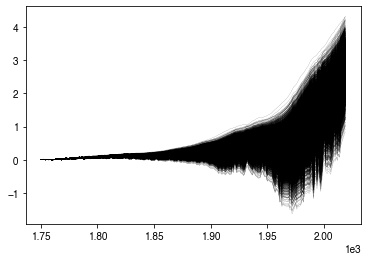

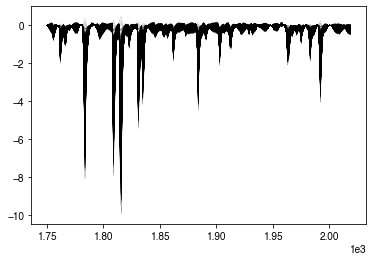

In [12]:
rf_ant.plot(legend=None,lw=0.1,c='k')

rf_nat.plot(legend=None,lw=0.1,c='k')

In [13]:
## create the response parameter ranges:

### based on inferred ranges from CMIP6
response_names = ['response_'+str(x) for x in np.arange(24)]
response_params = pd.DataFrame(index=['d','q'],columns = pd.MultiIndex.from_product([response_names,[1,2,3]])).apply(pd.to_numeric)
response_params.loc[:] = 0

d1_range = [0.2,0.8,1.4,2]
d2_range = [4,8,12,16]
d3_range = [100,200,400,800]
q1_range = [0.04,0.16,0.28,0.4]

RWF_range = [0.3 , 0.4 , 0.5, 0.6, 0.7, 0.8]
ECS=3

i=0
for d_num in np.arange(4):
    for RWF in RWF_range:
        response_params.loc['d',(response_names[i],1)] = d1_range[d_num]
        response_params.loc['d',(response_names[i],2)] = d2_range[d_num]
        response_params.loc['d',(response_names[i],3)] = d3_range[d_num]
        response_params.loc['q',(response_names[i],1)] = q1_range[d_num]

        q2,q3 = sp.optimize.root(lambda x: q_to_tcr_ecs(response_params.reindex([response_names[i]],axis=1,level=0) + [[0,0],[0,x[0]],[0,x[1]]],F_2x=3.76).values.flatten() - np.array([ECS,ECS*RWF]),x0=np.array([0.32,0.47]),method='lm').x

        response_params.loc['q',(response_names[i],2)] = q2
        response_params.loc['q',(response_names[i],3)] = q3

        i+=1
            
## remove any that are unphysical (negative parameters)

response_params = response_params.reindex([i for i,x in ((response_params<0).sum().unstack().sum(axis=1)==1).iteritems() if not x],axis=1,level=0)

In [14]:
## generate the temperature responses:

### reshape the rf dataframes into model inputs (only for old forcing data):
# rf_ant['YEAR'] = [x.year for x in rf_ant.index]
# rf_ant.set_index('YEAR',inplace=True)
# rf_ant.columns = pd.MultiIndex.from_product([['forcing_'+str(x) for x in rf_ant.columns],['forcing']])
# rf_ant = rf_ant.reindex(rf_ant.index.append(pd.Index([2018,2019])))
# rf_ant.loc[2018] = rf_ant.loc[2017]+(rf_ant.loc[2017] - rf_ant.loc[2012])/5
# rf_ant.loc[2019] = rf_ant.loc[2017]+2*(rf_ant.loc[2017] - rf_ant.loc[2012])/5

# rf_nat['YEAR'] = [x.year for x in rf_nat.index]
# rf_nat.set_index('YEAR',inplace=True)
# rf_nat.columns = pd.MultiIndex.from_product([['forcing_'+str(x) for x in rf_nat.columns],['forcing']])
# rf_nat.loc[2018] = rf_nat.loc[2017]+(rf_nat.loc[2017] - rf_nat.loc[2012])/5
# rf_nat.loc[2019] = rf_nat.loc[2017]+2*(rf_nat.loc[2017] - rf_nat.loc[2012])/5

##
temp_ant = run_GIR(emissions_in=return_empty_emissions(rf_ant),forcing_in=rf_ant,thermal_parameters=response_params)['T'].droplevel(1,axis=1)
temp_nat = run_GIR(emissions_in=return_empty_emissions(rf_nat),forcing_in=rf_nat,thermal_parameters=response_params)['T'].droplevel(1,axis=1)

Integrating 10000 scenarios, 1 gas cycle parameter sets, 18 independent thermal response parameter sets, over ['CH4', 'CO2', 'N2O'], between 1750 and 2019...


100%|██████████| 269/269 [00:17<00:00, 15.81 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 18 independent thermal response parameter sets, over ['CH4', 'CO2', 'N2O'], between 1750 and 2019...


100%|██████████| 269/269 [00:17<00:00, 15.12 timestep/s]


/home/leachl/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3263: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await self.run_code(code, result,  async_=asy)):
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

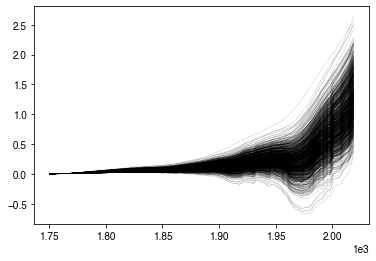

In [15]:
temp_ant.iloc[:,np.random.choice(18*N,1000)].plot(legend=False,lw=0.1,c='k')

In [16]:
## generate the temperature dataset:

temp_obs_med = GMST_datasets.mean(axis=1).loc[:'2019'].resample('Y').mean().values

temp_obs_unc = HadCRUT_ensmem.loc[:2019].values - HadCRUT_ensmem.loc[:2019].median(axis=1)[:,np.newaxis]

temp_obs_full = temp_obs_med[:,np.newaxis] + temp_obs_unc

In [17]:
# definition to compute the regressions:
def OLSE_NORM(X,Y,add_intercept=True):
    
    ## computes a multiple OLS regression over a field against several indices. First dimension is time, second is features (X), or targets (Y)
    
    if add_intercept:
    
        X_1 = np.concatenate((np.ones(X.shape[0])[:,np.newaxis],X),axis=1)
        
    else:
        
        X_1 = X.copy()
    
    B = np.dot( np.linalg.inv( np.dot( X_1.T , X_1 ) ) , np.dot( X_1.T , Y ) )
    
#     e = Y - np.dot(X_1,B)
    
#     SSE = np.sum(e**2,axis=0)

#     MSE_var = SSE / (X_1.shape[0] - X_1.shape[-1])

#     SE_B = np.sqrt( np.diag( np.linalg.inv( np.dot( X_1.T , X_1 ) ) )[:,np.newaxis] * MSE_var[np.newaxis,:] )
    return {'coefs':B[1:],'intercept':B[0]}
#     return {'coefs':B[1:],'coef_err':SE_B[1:],'res':e,'intercept':B[0],'intercept_err':SE_B[0]}

In [18]:
ant_coefs = np.empty((100,temp_ant.shape[1]))
nat_coefs = np.empty((100,temp_nat.shape[1]))

for i in tqdm.tqdm(np.arange(ant_coefs.shape[1])):
    _lreg_coefs = OLSE_NORM(np.array([temp_ant.iloc[100:,i].values,temp_nat.iloc[100:,i].values]).T,temp_obs_full)['coefs']
    ant_coefs[:,i] = _lreg_coefs[0]
    nat_coefs[:,i] = _lreg_coefs[1]
#     ant_coefs.iloc[:,i] = _lreg_coefs[0]
#     nat_coefs.iloc[:,i] = _lreg_coefs[1]

100%|██████████| 180000/180000 [04:43<00:00, 635.53it/s]


In [19]:
## computing the uncertainty from internal variability

### get internal variability timeseries:

CMIP6_int_var = pd.read_csv('../tools/cmip6_data/piControl_tas.csv',index_col=0)

### subsample 100 * 170 year slices
### check if drift, discard if drift
### randomly pick one non-drifting sample

CMIP6_int_var_samples = pd.DataFrame(index=np.arange(170))
for model,data in CMIP6_int_var.iteritems():
    arr = data.dropna().values
    chunksize = arr.size
    if chunksize<170:
        continue
    starting_points = np.random.choice(np.arange(chunksize-170),100)
    nodrift_points = []
    for s in starting_points:
        subarr = arr[s:s+170]
        drift = sp.stats.linregress(np.arange(170),subarr).slope
        if drift*100>0.15:
            continue
        else:
            nodrift_points+=[s]
    chosen_start = np.random.choice(nodrift_points)
    CMIP6_int_var_samples.loc[:,model] = arr[chosen_start:chosen_start+170] - arr[chosen_start:chosen_start+170].mean()

In [20]:
### remove model degeneracies:

int_var_models = []
for model in CMIP6_int_var_samples.columns:
    if [x.split('_')[1] for x in CMIP6_int_var_samples.columns].count(model.split('_')[1]) > 1:
        all_mems = [x for x in CMIP6_int_var_samples.columns if x.split('_')[1] == model.split('_')[1]]
        all_mems = [x.split('_')[2] for x in all_mems]
        curr_mem = model.split('_')[2]
        all_mem_nos = np.array([int(''.join(re.findall(r'\d+',mem))) for mem in all_mems])
        curr_mem_no = int(''.join(re.findall(r'\d+',curr_mem)))
        if all(curr_mem_no < all_mem_nos):
            int_var_models += [model]
            continue
    else:
        int_var_models += [model]
        
CMIP6_int_var_samples_nondeg = CMIP6_int_var_samples.loc[:,int_var_models]

<AxesSubplot:>

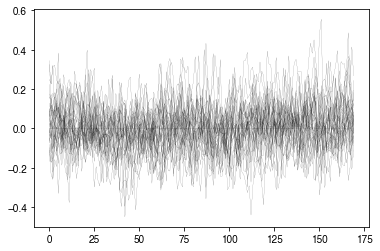

In [21]:
CMIP6_int_var_samples_nondeg.plot(legend=None,lw=0.1,c='k')

In [22]:
ant_coefs_iv = np.empty((CMIP6_int_var_samples_nondeg.columns.size,temp_ant.shape[1]))
nat_coefs_iv = np.empty((CMIP6_int_var_samples_nondeg.columns.size,temp_nat.shape[1]))

for i in tqdm.tqdm(np.arange(ant_coefs_iv.shape[1])):
    _lreg_coefs = OLSE_NORM(np.array([temp_ant.iloc[100:,i].values,temp_nat.iloc[100:,i].values]).T,CMIP6_int_var_samples_nondeg.values)['coefs']
    ant_coefs_iv[:,i] = _lreg_coefs[0]
    nat_coefs_iv[:,i] = _lreg_coefs[1]
#     ant_coefs_iv.iloc[:,i] = _lreg_coefs[0]
#     nat_coefs_iv.iloc[:,i] = _lreg_coefs[1]

100%|██████████| 180000/180000 [04:42<00:00, 636.75it/s]


In [23]:
chosen_year = 2014

## computing the present day value:
temp_attr_ant = pd.DataFrame(ant_coefs * (temp_ant.loc[chosen_year]-temp_ant.loc[baseline[0]:baseline[1]].mean()).values[np.newaxis,:],index=np.arange(100),columns=temp_ant.columns).unstack()
temp_attr_nat = pd.DataFrame(nat_coefs * (temp_nat.loc[chosen_year]-temp_nat.loc[baseline[0]:baseline[1]].mean()).values[np.newaxis,:],index=np.arange(100),columns=temp_ant.columns).unstack()

## computing the present day (2015-2019) rate:
temp_rate_attr_ant = pd.DataFrame(ant_coefs * OLSE_NORM(np.arange(5)[:,np.newaxis],temp_ant.loc[np.arange(chosen_year-4,chosen_year+1)].values)['coefs'],index=np.arange(100),columns=temp_ant.columns).unstack()
temp_rate_attr_nat = pd.DataFrame(nat_coefs * OLSE_NORM(np.arange(5)[:,np.newaxis],temp_nat.loc[np.arange(chosen_year-4,chosen_year+1)].values)['coefs'],index=np.arange(100),columns=temp_ant.columns).unstack()

## computing the present day value uncertainty from internal variability:
temp_attr_ant_iv = pd.DataFrame(ant_coefs_iv * (temp_ant.loc[chosen_year]-temp_ant.loc[baseline[0]:baseline[1]].mean()).values[np.newaxis,:],index=np.arange(CMIP6_int_var_samples_nondeg.columns.size),columns=temp_ant.columns).unstack()
temp_attr_nat_iv = pd.DataFrame(nat_coefs_iv * (temp_nat.loc[chosen_year]-temp_nat.loc[baseline[0]:baseline[1]].mean()).values[np.newaxis,:],index=np.arange(CMIP6_int_var_samples_nondeg.columns.size),columns=temp_ant.columns).unstack()

## computing the present day (2015-2019) rate uncertainty from internal variability:
temp_rate_attr_ant_iv = pd.DataFrame(ant_coefs_iv * OLSE_NORM(np.arange(5)[:,np.newaxis],temp_ant.loc[np.arange(chosen_year-4,chosen_year+1)].values)['coefs'],index=CMIP6_int_var_samples_nondeg.columns,columns=temp_ant.columns).unstack()
temp_rate_attr_nat_iv = pd.DataFrame(nat_coefs_iv * OLSE_NORM(np.arange(5)[:,np.newaxis],temp_nat.loc[np.arange(chosen_year-4,chosen_year+1)].values)['coefs'],index=CMIP6_int_var_samples_nondeg.columns,columns=temp_ant.columns).unstack()

In [24]:
## combine the sources of uncertainty:

temp_attr_ant_and_iv = (temp_attr_ant.unstack(level=2).values.reshape(N,18,-1,1) + temp_attr_ant_iv.unstack(level=2).values.reshape(N,18,1,-1)).astype(np.float32)
temp_attr_nat_and_iv = (temp_attr_nat.unstack(level=2).values.reshape(N,18,-1,1) + temp_attr_nat_iv.unstack(level=2).values.reshape(N,18,1,-1)).astype(np.float32)

temp_rate_attr_ant_and_iv = (temp_rate_attr_ant.unstack(level=2).values.reshape(N,18,-1,1) + temp_rate_attr_ant_iv.unstack(level=2).values.reshape(N,18,1,-1)).astype(np.float32)
temp_rate_attr_nat_and_iv = (temp_rate_attr_nat.unstack(level=2).values.reshape(N,18,-1,1) + temp_rate_attr_nat_iv.unstack(level=2).values.reshape(N,18,1,-1)).astype(np.float32)

In [27]:
# print('Anthro Temp statistics')
# print(temp_attr_ant.describe(percentiles=[.05,.16,.33,.5,.66,.84,.95]).T)

# print('\nAnthro Temp rate statistics')
# print(temp_rate_attr_ant.describe(percentiles=[.05,.16,.33,.5,.66,.84,.95]).T)

# print('\nTotal Temp statistics')
# print((temp_attr_ant+temp_attr_nat).describe(percentiles=[.05,.16,.33,.5,.66,.84,.95]).T)

# print('\nTotal Temp rate statistics')
# print((temp_rate_attr_ant+temp_rate_attr_nat).describe(percentiles=[.05,.16,.33,.5,.66,.84,.95]).T)

HIGH_constrain_level,LOW_constrain_level = np.quantile(temp_attr_ant_and_iv+temp_attr_nat_and_iv,[0.95,0.05])
HIGH_constrain_rate,LOW_constrain_rate = np.quantile(temp_rate_attr_ant_and_iv+temp_rate_attr_nat_and_iv,[0.95,0.05])

print('Temp level constraint:')
print(np.quantile(temp_attr_ant_and_iv+temp_attr_nat_and_iv,[0.05,0.5,0.95]))

print('\nTemp rate constraint:')
print(np.quantile(temp_rate_attr_ant_and_iv+temp_rate_attr_nat_and_iv,[0.05,0.5,0.95]))

Temp level constraint:
[0.67395639 1.06875932 1.2597369 ]

Temp rate constraint:
[0.02091439 0.03002626 0.0422343 ]


Text(0, 0.5, 'rate of temperature change over 2015-2019 / K decade$^{-1}$')

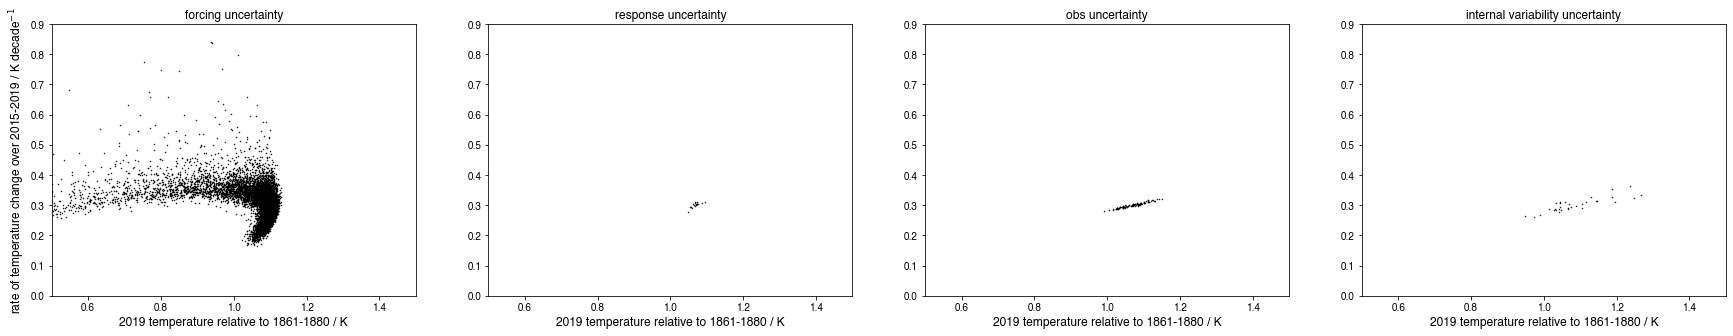

In [29]:
fig,ax=plt.subplots(1,4,figsize=(30,5))
# ax[0].hist2d((temp_attr_ant_and_iv+temp_attr_nat_and_iv).flatten(),10*(temp_rate_attr_ant_and_iv+temp_rate_attr_nat_and_iv).flatten(),bins=500,cmap='binary',density=True)

for i,source in enumerate(['forcing','response','obs','internal variability']):
    ax[i].scatter(np.median(temp_attr_ant_and_iv+temp_attr_nat_and_iv,axis=(np.arange(1,4)+i)%4),10*np.median(temp_rate_attr_ant_and_iv+temp_rate_attr_nat_and_iv,axis=(np.arange(1,4)+i)%4),color='k',marker='.',s=1)
    ax[i].set_title(source+' uncertainty')
    
[a.set_xlim(0.5,1.5) for a in ax]
[a.set_ylim(0.0,0.9) for a in ax]
[a.set_xlabel('2019 temperature relative to 1861-1880 / K',fontsize=12) for a in ax]
ax[0].set_ylabel('rate of temperature change over 2015-2019 / K decade$^{-1}$',fontsize=12)
# ax[0].set_title('FULL uncertainty',fontsize=12)

## Part II: constraining a large parameter ensemble

In [2]:
## start from here if you don't want to re-run the GWI:
baseline = [1861,1880]
chosen_year = 2014
HIGH_constrain_level,LOW_constrain_level = [1.2597369 , 0.67395639]
HIGH_constrain_rate,LOW_constrain_rate = [0.0422343 , 0.02091439]

#### Forcing parameter uncertainties
We construct ensembles of the ERF parameters used in the model by scaling each default ERF parameter by a scaling factor sampled from the appropriate distribution:
- CO$_2$ ~ $\mathcal{N}\left(1,\frac{0.2}{\Phi^{-1}(0.95)}\right)$
- CH$_4$ ~ $\mathcal{N}\left(1,\frac{0.28}{\Phi^{-1}(0.95)}\right)$
- N$_2$O ~ $\mathcal{N}\left(1,\frac{0.2}{\Phi^{-1}(0.95)}\right)$
- other WMGHGs ~ $\mathcal{N}\left(1,\frac{0.2}{\Phi^{-1}(0.95)}\right)$
- tropospheric O$_3$ ~ $\mathcal{N}\left(1,\frac{0.5}{\Phi^{-1}(0.95)}\right)$
- stratospheric O$_3$ ~ $\mathcal{N}\left(1,\frac{2}{\Phi^{-1}(0.95)}\right)$
- stratospheric H$_2$O from CH$_4$ ~ $\mathcal{N}\left(1,\frac{0.72}{\Phi^{-1}(0.95)}\right)$
- BC on snow ~ lognormal with quantiles 0.05 = 0.5 and 0.95 = 2.25
- contrails ~ $\mathcal{N}\left(1,\frac{0.75}{\Phi^{-1}(0.95)}\right)$
- ERFari ~ $\alpha$ parameters drawn from CMIP6 inferred multivariate normal; resulting distribution scaled to match process based assessment in Bellouin (2020)
- ERFaci ~ parameters drawn independently from CMIP6 inferred distribution; resulting distribtuion scaled to match process based assessment Bellouin (2020)
- LUC ~ $\mathcal{N}\left(1,\frac{0.75}{\Phi^{-1}(0.95)}\right)$
- volcanic ~ $\mathcal{N}\left(1,\frac{0.5}{\Phi^{-1}(0.95)}\right)$
- solar ~ $\mathcal{N}\left(1,\frac{1}{\Phi^{-1}(0.95)}\right)$

N.B. the numerator in each normal distribution scale parameter gives the half the 90% confidence interval (ie. uncertainty in CO$_2$ ERF is $\pm20\%$).

In [3]:
## create parameter ensemble

### do we go for sampling gaussian forcings / non-gaussian forcings / carbon-cycle parameters / response parameters independently
### and assuming all uncertainties within these categories are correlated?

default_params = pd.read_csv('../Parameter_Sets/Complete_gas_cycle_params.csv',skiprows=1,index_col=0)
forcing_namelist = list(default_params.columns)

param_categories = {}
param_categories['other_wmghgs'] = ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8','carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methyl_bromide', 'methyl_chloride', 'nf3', 'sf6', 'so2f2', 'halon1202']
param_categories['carbon_dioxide'] = ['carbon_dioxide']
param_categories['methane'] = ['methane']
param_categories['nitrous_oxide'] = ['nitrous_oxide']
param_categories['trop_o3'] = [x for x in forcing_namelist if '|trop_o3' in x]
param_categories['strat_o3'] = [x for x in forcing_namelist if '|strat_o3' in x]
param_categories['strat_h2o'] = [x for x in forcing_namelist if '|strat_h2o' in x]
param_categories['ari'] = ['so2', 'nox', 'co', 'nmvoc', 'bc', 'nh3','oc','nox_avi']
param_categories['aci'] = ['so2|aci','oc|aci','bc|aci']
param_categories['bc_on_snow'] = ['bc|bc_on_snow']
param_categories['contrails'] = ['nox_avi|contrails']

def get_forcing_param_ensemble(N,mem_names = False):
    
    if mem_names is False:
        mem_names = ['mem'+str(x) for x in np.arange(N)]
    
    category_distributions = pd.Series(index = param_categories.keys(),dtype=object)

    category_distributions.loc['carbon_dioxide'] = sp.stats.norm(1,0.20/1.645)
    category_distributions.loc['methane'] = sp.stats.norm(1,0.28/1.645)
    category_distributions.loc['nitrous_oxide'] = sp.stats.norm(1,0.2/1.645)
    category_distributions.loc['other_wmghgs'] = sp.stats.norm(1,0.20/1.645)
    category_distributions.loc['trop_o3'] = sp.stats.norm(1,0.5/1.645)
    category_distributions.loc['strat_o3'] = sp.stats.norm(1,2/1.645)
    category_distributions.loc['strat_h2o'] = sp.stats.norm(1,0.72/1.645)
    pct_5 = 0.04 / 0.08 # need to scale by the mean to turn into a "scaling factor"
    pct_95=0.18 / 0.08
    sigma = (np.log(pct_95) - np.log(pct_5)) / (sp.stats.norm().ppf(0.95)-sp.stats.norm().ppf(0.05))
    mu = np.log(pct_5) - sigma * sp.stats.norm().ppf(0.05)
    category_distributions.loc['bc_on_snow'] = sp.stats.lognorm(s=sigma,scale=np.exp(mu))
    category_distributions.loc['contrails'] = sp.stats.norm(1,0.75/1.645)

    f_parameter_ensemble_draw = np.zeros((3,len(forcing_namelist),N))
    default_f_params = default_params.loc['f1':'f3'].values

    for key in category_distributions.index:
        if not type(category_distributions.loc[key]) == sp.stats._distn_infrastructure.rv_frozen:
            continue
        cat_map = [x in param_categories[key] for x in forcing_namelist]
        f_parameter_ensemble_draw[:,cat_map,:] = default_f_params[:,cat_map,None] * category_distributions.loc[key].rvs(N)[None,None]
        
    ## draw aerosol parameters based on inferred CMIP6 ranges, then rescaled to match the Bellouin process based assessment

    ## compute parameters, then scale by the Bellouin / 1850-(2005:2015)

    ERFari_params = pd.DataFrame(data=np.array([[ 3.25934432e-02, -3.46653116e-04, -2.48761587e-03],
           [ 2.48231885e-02, -1.26321908e-02, -9.42090973e-04],
           [ 2.68560170e-02, -2.08950151e-03, -2.60579679e-03],
           [ 1.01700746e-01, -3.04192033e-02, -2.63868473e-03],
           [ 1.46132214e-01, -4.41485999e-02, -6.67827786e-03],
           [ 1.95732170e-03,  4.15481407e-03, -2.90822562e-03],
           [-5.61261154e-02,  8.85201623e-03, -7.47602910e-04],
           [ 3.87211606e-02, -1.42408227e-02, -1.78155606e-03],
           [ 3.02173214e-03, -3.40228173e-03, -1.25702781e-03],
           [ 2.54832726e-03,  6.32322444e-05, -2.38863636e-03]]),index=['CanESM5', 'E3SM', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G',
           'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'NorESM2-LM',
           'UKESM1-0-LL'],columns=['bc', 'oc', 'so2'])

    ### LOG so2 ERFaci params
    ERFaci_params = pd.DataFrame(data=np.array([[-8.04936152e-01, -4.33765114e+00, -1.76516101e-02],
           [ 4.20348167e-01, -4.19165818e+00, -1.57827154e-02],
           [ 1.67034191e+00, -5.34562320e+00, -8.80674737e-03],
           [ 2.25088976e+00, -5.57251763e+00, -1.19361347e-02],
           [-1.80621064e+00, -4.82004944e+00, -1.88411062e-02],
           [-1.48244252e-01, -4.48450777e+00, -6.70740113e-03],
           [ 1.03705925e+00, -5.88364385e+00, -1.91422284e-03],
           [-1.00837014e+00, -4.73118298e+00, -1.30437040e-02],
           [ 2.07731610e+00, -5.03084334e+00, -1.39245898e-02],
           [-2.52178641e-01, -3.93423009e+00,  3.35367830e-03]])

    ,index=['CanESM5', 'E3SM', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G',
           'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'NorESM2-LM',
           'UKESM1-0-LL'],columns=['log_beta', 'log_beta_s', 'alpha'])

    ERFari_param_draw = sp.stats.multivariate_normal(ERFari_params.mean(),ERFari_params.cov()).rvs(N)

    ERFaci_beta_s = np.exp(sp.stats.multivariate_normal(ERFaci_params.loc[:,['log_beta','log_beta_s']].mean(),ERFaci_params.loc[:,['log_beta','log_beta_s']].cov()).rvs(N))
    ERFaci_alpha = sp.stats.norm(ERFaci_params.loc[:,'alpha'].mean(),ERFaci_params.loc[:,'alpha'].std()).rvs(N)
    ERFaci_beta = -1*ERFaci_beta_s[...,0]
    ERFaci_s = ERFaci_beta_s[...,0] / ERFaci_beta_s[...,1]
    
    ## get aerosol emissions
    RCMIP_aer_emms = RCMIP_emms.loc[('World','ssp245',['Emissions|Sulfur','Emissions|OC','Emissions|BC'])].iloc[:,4:].droplevel((0,1)).apply(pd.to_numeric).T.interpolate().loc[:'2019']
    ## baseline to be zero in 1750
    RCMIP_aer_emms -= RCMIP_aer_emms.loc['1750']

    ## generate the 1850 - 2010 change
    ERFari_1850_2010 = ((RCMIP_aer_emms.loc['2005':'2010'].mean() - RCMIP_aer_emms.loc['1850']).values * ERFari_param_draw).sum(axis=1)

    ERFaci_1850_2010 = ERFaci_beta * ( np.log(1 + RCMIP_aer_emms.loc['2005':'2010','Emissions|Sulfur'].mean()/ERFaci_s) - np.log(1 + RCMIP_aer_emms.loc['1850','Emissions|Sulfur'].mean()/ERFaci_s) ) \
    + ERFaci_alpha * (RCMIP_aer_emms.loc['2005':'2010',['Emissions|OC','Emissions|BC']].mean().sum() - RCMIP_aer_emms.loc['1850',['Emissions|OC','Emissions|BC']].sum())
    
    # Use Nicolas' Ringberg methods
    def uniform1684(a,b,seed,samples=2000):
        interval = (b-a)+((b-a)/(84-16)*32)
        lower = a-((b-a)/(84-16)*16)
        return sp.stats.uniform.rvs(lower, interval, size=samples, random_state=seed)
    samples=N
    dtau    = uniform1684(0.02,0.04,123,samples=samples)
    tau     = uniform1684(0.13,0.17,124,samples=samples)
    S_tau   = uniform1684(-27,-20,125,samples=samples)
    RFari_cloudy = uniform1684(-0.1,0.1,126,samples=samples)
    dR_dRatm = uniform1684(-0.3,-0.1,127,samples=samples)
    dRatm_dtau = uniform1684(17,35,128,samples=samples)
    c_tau    = uniform1684(0.59,0.71,129,samples=samples)
    c_N      = uniform1684(0.19,0.29,130,samples=samples)
    c_L      = uniform1684(0.21,0.29,131,samples=samples)
    c_C      = uniform1684(0.59,1.07,132,samples=samples)
    beta_N_tau = uniform1684(0.3,0.8,133,samples=samples)
    beta_L_N   = uniform1684(-0.36,-0.011,134,samples=samples)
    beta_C_N   = uniform1684(0,0.1,135,samples=samples)
    S_N = uniform1684(-27,-26,136,samples=samples)
    S_L = uniform1684(-56,-54,137,samples=samples)
    S_C = uniform1684(-153,-91,138,samples=samples)

    rfari = dtau*S_tau*(1-c_tau)+RFari_cloudy
    rfari_adj = dtau*dR_dRatm*dRatm_dtau

    dlntau = dtau/tau
    deltan = dlntau * beta_N_tau

    rfaci = dlntau*beta_N_tau*S_N*c_N
    erfaci_L = dlntau*beta_N_tau*beta_L_N*S_L*c_L
    erfaci_C = dlntau*beta_N_tau*beta_C_N*S_C*c_C

    ERFari_scale = rfari + rfari_adj
    ERFaci_scale = rfaci + erfaci_L + erfaci_C
    
    def np_quantileatscore(a,score):
    
        return ( (a[:,np.newaxis,...]<score[np.newaxis,...]).sum(axis=0) + (a[:,np.newaxis,...]<=score[np.newaxis,...]).sum(axis=0) ) / (2*a.shape[0])

    ERFari_qmap = (ERFari_scale[np.argsort(ERFari_scale)][(np_quantileatscore(ERFari_1850_2010,ERFari_1850_2010)*N).astype(int)] / ERFari_1850_2010)
    ERFaci_qmap = (ERFaci_scale[np.argsort(ERFaci_scale)][(np_quantileatscore(ERFaci_1850_2010,ERFaci_1850_2010)*N).astype(int)] / ERFaci_1850_2010)
    
    for i,cat in enumerate(['bc','oc','so2']):
        cat_map = forcing_namelist.index(cat)
        f_parameter_ensemble_draw[1,cat_map,:] = ERFari_param_draw[...,i]*ERFari_qmap

    so2_PI_conc_ensemble = ERFaci_s.copy()

    cat_map = forcing_namelist.index('so2|aci')
    f_parameter_ensemble_draw[0,cat_map,:] = ERFaci_beta*ERFaci_qmap

    cat_map = forcing_namelist.index('oc|aci')
    f_parameter_ensemble_draw[1,cat_map,:] = ERFaci_alpha*ERFaci_qmap
    cat_map = forcing_namelist.index('bc|aci')
    f_parameter_ensemble_draw[1,cat_map,:] = ERFaci_alpha*ERFaci_qmap
    
    gas_parameter_ensemble = pd.concat([default_params.copy()]*N,axis=1,keys=mem_names)

    gas_parameter_ensemble.loc['f1':'f3',:] = f_parameter_ensemble_draw.swapaxes(1,2).reshape(3,-1)[:]

    gas_parameter_ensemble.loc['PI_conc',(slice(None),'so2')] = so2_PI_conc_ensemble[:]
    
    return gas_parameter_ensemble

#### Response parameter uncertainties

In [4]:
def get_response_params(N,gas_parameter_ensemble,mem_names = False):
    
    if mem_names is False:
        mem_names = ['mem'+str(x) for x in np.arange(N)]
    
    ## require gas_params for the F_2x value

    ## draw ln d1, d2, q1 | RWF , d3 | TCR

    # covariance of ln_d1, d2, q1
    cov_mat_1 = np.array([[2.94358445e-01, 5.58963469e-01, 3.49480987e-02],
           [5.58963469e-01, 7.05140407e+00, 1.26045312e-01],
           [3.49480987e-02, 1.26045312e-01, 6.51046487e-03]])

    mean_mat_1 = np.array([-0.08642002,  8.16552935,  0.20359601])

    # covariance of RWF, d3
    cov_mat_2 = np.array([[ 1.44088893e-02, -6.69645898e+00],
           [-6.69645898e+00,  6.34183337e+03]])

    mean_mat_2 = np.array([  0.54430983, 261.86477998])

    F_2x = gas_parameter_ensemble.loc['f1',(slice(None),'carbon_dioxide')].values * np.log(2) + gas_parameter_ensemble.loc['f3',(slice(None),'carbon_dioxide')].values * (np.sqrt(278*2) - np.sqrt(278))

    lnd1 , d2 , q1 , RWF , d3 , TCR , d1 , ECS , v1 , v2 , v3 , q2 , q3 = np.empty((13,N))

    neg_idx = np.ones(N).astype(bool)
    N_neg = neg_idx.sum()

    while N_neg>0:

        lnd1[neg_idx], d2[neg_idx], q1[neg_idx] = sp.stats.multivariate_normal(mean_mat_1,cov_mat_1).rvs(N_neg).T
        RWF[neg_idx], d3[neg_idx] = sp.stats.multivariate_normal(mean_mat_2,cov_mat_2).rvs(N_neg).T
        TCR[neg_idx] = sp.stats.norm(1.85, 0.75).rvs(N_neg)
        d1[neg_idx] = np.exp(lnd1[neg_idx])
        ECS[neg_idx] = TCR[neg_idx]/RWF[neg_idx]

        v1[neg_idx] = (1-(d1/69.66) * (1-np.exp(-69.66/d1)) )[neg_idx]
        v2[neg_idx] = (1-(d2/69.66) * (1-np.exp(-69.66/d2)) )[neg_idx]
        v3[neg_idx] = (1-(d3/69.66) * (1-np.exp(-69.66/d3)) )[neg_idx]

        q3[neg_idx] = (((TCR/F_2x) - q1*(v1-v2) - (ECS/F_2x)*v2) / (v3-v2))[neg_idx]
        q2[neg_idx] = (ECS/F_2x - q1 -  q3)[neg_idx]

        neg_idx = np.any(np.array([d1,d2,d3,q1,q2,q3])<0,axis=0)
        N_neg = neg_idx.sum()

    response_par_ensemble = np.array([d1,d2,d3,q1,q2,q3]).T
    thermal_parameter_ensemble = pd.concat([get_thermal_parameter_defaults()['default'].copy()]*N,axis=1,keys=mem_names)
    thermal_parameter_ensemble.loc[:] = response_par_ensemble.reshape(N,2,3).swapaxes(0,1).reshape(2,-1)
    
    return thermal_parameter_ensemble

We run in chunks of 10,000 at a time to reduce the RAM consumption

In [5]:
def run_CONSTRAIN(N,ssp='ssp245',mem_names=False):
    
    if mem_names is False:
        mem_names = ['mem'+str(x) for x in np.arange(N)]
    
    # forcing uncertainty
    ## anothropogenic
    gas_parameter_ensemble = get_forcing_param_ensemble(10000,mem_names=mem_names)
    
    erf_ar6 = pd.read_csv('https://raw.githubusercontent.com/Priestley-Centre/ssp_erf/master/SSPs/ERF_'+ssp+'_1750-2500.csv',index_col=0,dtype=float)
    ## LUC
    LUC_forc = erf_ar6[['land_use']].reindex(np.arange(1750,2101)).values
    LUC_forc_ensemble = sp.stats.norm(1,0.75/1.645).rvs(N)[None] * LUC_forc
    
    ## Natural
    volc_forc = erf_ar6[['volcanic']].reindex(np.arange(1750,2101)).values
    volc_forc_ensemble = sp.stats.norm(1,0.5/1.645).rvs(N)[None] * volc_forc
    sol_forc = erf_ar6[['solar']].reindex(np.arange(1750,2101)).values
    sol_forc_ensemble = sp.stats.norm(1,1/1.645).rvs(N)[None] * sol_forc
    
    ssp_forc = pd.DataFrame(LUC_forc_ensemble+sol_forc_ensemble+volc_forc_ensemble,index=np.arange(1750,2101),columns=pd.MultiIndex.from_product([mem_names,['forcing']]) )
    
    # carbon cycle uncertainty
    cc_param_draw = sp.stats.norm(1,0.13/1.645).rvs(N).reshape(1,-1)
    gas_parameter_ensemble.loc['r0':'rT',(slice(None),'carbon_dioxide')] = gas_parameter_ensemble.loc['r0':'rT',(slice(None),'carbon_dioxide')].values * cc_param_draw
    
    # response uncertainty
    thermal_parameter_ensemble = get_response_params(10000,gas_parameter_ensemble,mem_names)
    
    # get ssp emissions
    ssp_emms = RCMIP_to_GIR_input_emms(ssp).interpolate().reindex(np.arange(1750,2101))
    ssp_emms -= ssp_emms.loc[1750] # emissions relative to 1750 values
    ssp_emms = pd.concat([ssp_emms]*N,axis=1,keys=mem_names)
    
    # run the model
    FULL = run_GIR(emissions_in=ssp_emms,forcing_in=ssp_forc,gas_parameters=gas_parameter_ensemble,thermal_parameters=thermal_parameter_ensemble)
    
    # get the constraints:
    temp_constraint = ((FULL['T'].loc[chosen_year]-FULL['T'].loc[baseline[0]:baseline[1]].mean())<HIGH_constrain_level)&((FULL['T'].loc[chosen_year]-FULL['T'].loc[baseline[0]:baseline[1]].mean())>LOW_constrain_level)
    rate_constraint = (FULL['T'].diff(5).loc[chosen_year]/5<HIGH_constrain_rate)&(FULL['T'].diff(5).loc[chosen_year]/5>LOW_constrain_rate)
    
    _output = pd.DataFrame(index=['ECS','TCR'],columns=FULL['T'].columns.levels[-1])

    f = gas_parameter_ensemble.loc['f1':'f3',(slice(None),'carbon_dioxide')].values
    F_2x = f[0]*np.log(2)+f[2]*(np.sqrt(278*2)-np.sqrt(278))
    _output.loc['ECS',:] = F_2x*thermal_parameter_ensemble.loc['q'].values.reshape(-1,3).sum(axis=1)
    _output.loc['TCR',:] = F_2x * ( thermal_parameter_ensemble.loc['q'].values.reshape(-1,3) * (1 - (thermal_parameter_ensemble.loc['d'].values.reshape(-1,3)/69.66) * ( 1 - np.exp(-69.66/thermal_parameter_ensemble.loc['d'].values.reshape(-1,3)) ) ) ).sum(axis=1)
        
    _output.loc['T_2100',:] = (FULL['T'].loc[2100] - FULL['T'].loc[baseline[0]:baseline[1]].mean()).reset_index(level=0).set_index('Scenario').iloc[:,0]
    
    for forc_cat in param_categories.keys():
    
        _output.loc[forc_cat+'_2019',:] = FULL['RF'].loc[2019,(slice(None),param_categories[forc_cat])].groupby(level=0).sum()
        
    _output.loc['GHG_2019',:] = _output.loc[[x+'_2019' for x in ['other_wmghgs', 'carbon_dioxide', 'methane', 'nitrous_oxide', 'trop_o3', 'strat_o3', 'strat_h2o']]].sum()
    _output.loc['aer_2019',:] = _output.loc[[x+'_2019' for x in ['aci','ari']]].sum()
    _output.loc['anthro_2019',:] = _output.loc[[x+'_2019' for x in param_categories.keys()]].sum()
    
    _output.loc['constrain_level',:] = temp_constraint.reset_index(level=0).set_index('Scenario').iloc[:,0]
    _output.loc['constrain_rate',:] = rate_constraint.reset_index(level=0).set_index('Scenario').iloc[:,0]
    _output.loc['constrain_multi',:] = (temp_constraint&rate_constraint).reset_index(level=0).set_index('Scenario').iloc[:,0]
    
    gas_parameter_ensemble.to_pickle('../Parameter_Sets/NROY/gas_params_'+mem_names[0]+'-'+mem_names[-1]+'.pkl')
    thermal_parameter_ensemble.to_pickle('../Parameter_Sets/NROY/response_params_'+mem_names[0]+'-'+mem_names[-1]+'.pkl')
    temp_constraint.to_pickle('../Parameter_Sets/NROY/temp_constraint_'+mem_names[0]+'-'+mem_names[-1]+'.pkl')
    rate_constraint.to_pickle('../Parameter_Sets/NROY/rate_constraint_'+mem_names[0]+'-'+mem_names[-1]+'.pkl')
    
    return _output

In [6]:
## run a total of 100,000 ensembles:
results = []
for i in np.arange(10):
    results+=[run_CONSTRAIN(10000,mem_names=['mem'+str(x) for x in np.arange(10000*(i),10000*(i+1))])]

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 independent thermal response parameter sets, over ['bc', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc11', 'cfc113', 'cfc114', 'cfc115', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'co', 'halon1202', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nh3', 'nitrous_oxide', 'nmvoc', 'nox', 'nox_avi', 'oc', 'sf6', 'so2', 'so2f2'], between 1750 and 2100...


100%|██████████| 350/350 [00:26<00:00, 13.14 timestep/s]
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in subtract


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 independent thermal response parameter sets, over ['bc', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc11', 'cfc113', 'cfc114', 'cfc115', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'co', 'halon1202', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nh3', 'nitrous_oxide', 'nmvoc', 'nox', 'nox_avi', 'oc', 'sf6', 'so2', 'so2f2'], between 1750 and 2100...


100%|██████████| 350/350 [00:26<00:00, 13.11 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 independent thermal response parameter sets, over ['bc', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc11', 'cfc113', 'cfc114', 'cfc115', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'co', 'halon1202', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nh3', 'nitrous_oxide', 'nmvoc', 'nox', 'nox_avi', 'oc', 'sf6', 'so2', 'so2f2'], between 1750 and 2100...


100%|██████████| 350/350 [00:26<00:00, 13.15 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 independent thermal response parameter sets, over ['bc', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc11', 'cfc113', 'cfc114', 'cfc115', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'co', 'halon1202', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nh3', 'nitrous_oxide', 'nmvoc', 'nox', 'nox_avi', 'oc', 'sf6', 'so2', 'so2f2'], between 1750 and 2100...


100%|██████████| 350/350 [00:26<00:00, 13.08 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 independent thermal response parameter sets, over ['bc', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc11', 'cfc113', 'cfc114', 'cfc115', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'co', 'halon1202', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nh3', 'nitrous_oxide', 'nmvoc', 'nox', 'nox_avi', 'oc', 'sf6', 'so2', 'so2f2'], between 1750 and 2100...


100%|██████████| 350/350 [00:26<00:00, 13.11 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 independent thermal response parameter sets, over ['bc', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc11', 'cfc113', 'cfc114', 'cfc115', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'co', 'halon1202', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nh3', 'nitrous_oxide', 'nmvoc', 'nox', 'nox_avi', 'oc', 'sf6', 'so2', 'so2f2'], between 1750 and 2100...


100%|██████████| 350/350 [00:27<00:00, 12.63 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 independent thermal response parameter sets, over ['bc', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc11', 'cfc113', 'cfc114', 'cfc115', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'co', 'halon1202', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nh3', 'nitrous_oxide', 'nmvoc', 'nox', 'nox_avi', 'oc', 'sf6', 'so2', 'so2f2'], between 1750 and 2100...


100%|██████████| 350/350 [00:27<00:00, 12.81 timestep/s]
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 independent thermal response parameter sets, over ['bc', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc11', 'cfc113', 'cfc114', 'cfc115', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'co', 'halon1202', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nh3', 'nitrous_oxide', 'nmvoc', 'nox', 'nox_avi', 'oc', 'sf6', 'so2', 'so2f2'], between 1750 and 2100...


100%|██████████| 350/350 [00:26<00:00, 13.17 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 independent thermal response parameter sets, over ['bc', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc11', 'cfc113', 'cfc114', 'cfc115', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'co', 'halon1202', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nh3', 'nitrous_oxide', 'nmvoc', 'nox', 'nox_avi', 'oc', 'sf6', 'so2', 'so2f2'], between 1750 and 2100...


100%|██████████| 350/350 [00:26<00:00, 13.09 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 independent thermal response parameter sets, over ['bc', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc11', 'cfc113', 'cfc114', 'cfc115', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'co', 'halon1202', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nh3', 'nitrous_oxide', 'nmvoc', 'nox', 'nox_avi', 'oc', 'sf6', 'so2', 'so2f2'], between 1750 and 2100...


100%|██████████| 350/350 [00:27<00:00, 12.93 timestep/s]


In [17]:
FULL_results = pd.concat(results,axis=1).apply(pd.to_numeric)

## Analysis of output

In [157]:
def custom_kde(x,y,ax,**kws):
    
    ## first remove the FAR outliers from x and y in turn
    
    x_rank = np.argsort(x)
    x = x[x_rank]
    y = y[x_rank]
    num_outlier_high = -1*(x>(x.mean()+7*x.std())).sum()
    num_outlier_low = (x<(x.mean()-7*x.std())).sum()
    if not num_outlier_high:
        num_outlier_high = None
    if not num_outlier_low:
        num_outlier_low = None
    x = x[num_outlier_low:num_outlier_high]
    y = y[num_outlier_low:num_outlier_high]


    y_rank = np.argsort(y)
    x = x[y_rank]
    y = y[y_rank]
    num_outlier_high = -1*(y>(y.mean()+7*y.std())).sum()
    num_outlier_low = (y<(y.mean()-7*y.std())).sum()
    if not num_outlier_high:
        num_outlier_high = None
    if not num_outlier_low:
        num_outlier_low = None
    x = x[num_outlier_low:num_outlier_high]
    y = y[num_outlier_low:num_outlier_high]
    
    gridsize=100
    k = sp.stats.kde.gaussian_kde([x,y])
    xi,yi = np.mgrid[x.min()-0.5:x.max()+0.5:gridsize*1j,y.min()-0.5:y.max()+0.5:gridsize*1j]
    zi = k(np.vstack([xi.flatten(),yi.flatten()])).reshape(xi.shape)
    dens_vals = np.linspace(0,zi.max(),gridsize)
    zi_int = ((zi>=dens_vals[:,None,None])*zi).sum(axis=(1,2))/zi.sum()
    zi_int_to_dens = sp.interpolate.interp1d(zi_int,dens_vals)
    dens_contours = zi_int_to_dens([0.95,0.67,0.33,0.05])
    kdeplot = ax.contour(xi,yi,zi,dens_contours,colors=kws['color'])
    return ax

In [158]:
FULL_results.index

Index(['ECS', 'TCR', 'T_2100', 'other_wmghgs_2019', 'carbon_dioxide_2019',
       'methane_2019', 'nitrous_oxide_2019', 'trop_o3_2019', 'strat_o3_2019',
       'strat_h2o_2019', 'ari_2019', 'aci_2019', 'bc_on_snow_2019',
       'contrails_2019', 'GHG_2019', 'aer_2019', 'anthro_2019',
       'constrain_level', 'constrain_rate', 'constrain_multi'],
      dtype='object')

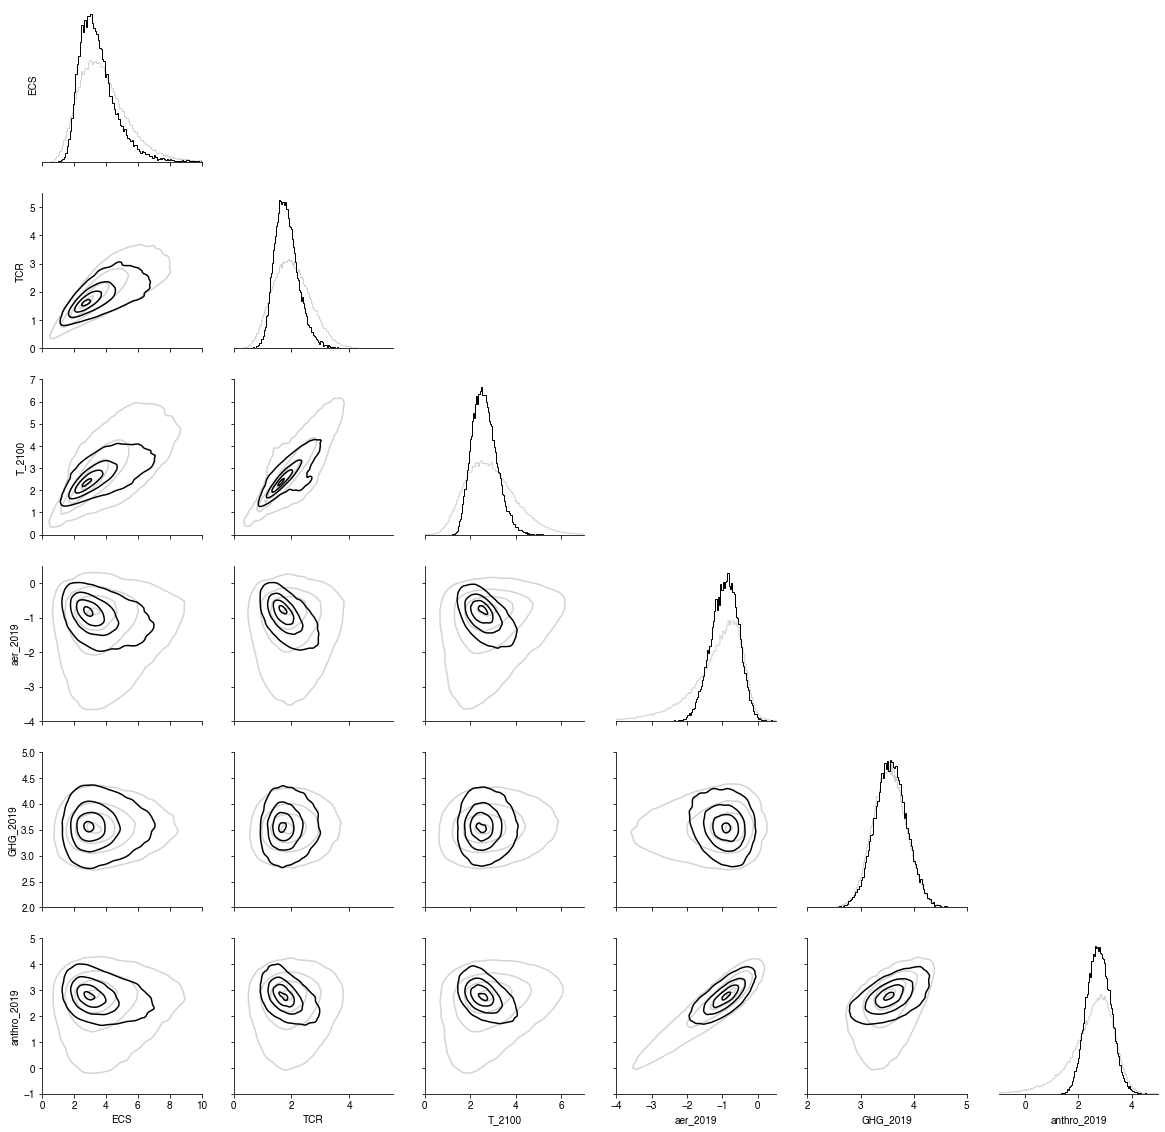

In [159]:
## create a correlation matrix plot:

cor_vars = ['ECS','TCR','T_2100','aer_2019','GHG_2019','anthro_2019']

fig,ax = plt.subplots(len(cor_vars),len(cor_vars),figsize=(20,20))

[ax[i,j].set_visible(False) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j>i]

## plot the distributions:

for i in np.arange(len(cor_vars)):
    ax[i,i].hist(FULL_results.loc[cor_vars[i]].values.flatten(),histtype='step',color='lightgrey',density=True)
    ax[i,i].hist(FULL_results.loc[cor_vars[i],FULL_results.loc['constrain_multi'].astype(bool)].values.flatten(),histtype='step',color='k',density=True)
    
## do some kde plots
[custom_kde(FULL_results.loc[cor_vars[j]].values.flatten(),FULL_results.loc[cor_vars[i]].values.flatten(),ax[i,j],color='lightgrey') for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j<i]
[custom_kde(FULL_results.loc[cor_vars[j],FULL_results.loc['constrain_multi'].astype(bool)].values.flatten(),FULL_results.loc[cor_vars[i],FULL_results.loc['constrain_multi'].astype(bool)].values.flatten(),ax[i,j],color='k') for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j<i]

axes_lims = [[0,10],[0,5.5],[0,7],[-4,0.5],[2,5],[-1,5]]

[ax[i,j].set_xlim(axes_lims[j]) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars))]
[ax[i,j].set_ylim(axes_lims[i]) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j<i]
[ax[i,j].set_ylabel(cor_vars[i]) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j==0]
[ax[i,j].set_xlabel(cor_vars[j]) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if i==5]

## diagonal axes
[ax[i,i].spines[pos].set_visible(False) for i in np.arange(len(cor_vars)) for pos in ['top','right','left']]
[ax[i,i].tick_params(left=False,labelleft=False) for i in np.arange(len(cor_vars))]

[ax[i,j].spines[pos].set_visible(False) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) for pos in ['top','right']]
[ax[i,j].tick_params(labelleft=False) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j!=0]
[ax[i,j].tick_params(labelbottom=False) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if i!=5]

print()

In [165]:
FULL_results.loc[:,FULL_results.loc['constrain_multi'].astype(bool)].T.describe(percentiles=[.05,.16,.33,.5,.66,.84,.95]).T.round(2)

,count,mean,std,min,5%,16%,33%,50%,66%,84%,95%,max
ECS,29541.0,3.51,1.26,0.42,1.99,2.41,2.86,3.28,3.75,4.57,5.81,19.10
TCR,29541.0,1.82,0.42,0.24,1.22,1.41,1.60,1.77,1.95,2.22,2.58,4.20
T_2100,29541.0,2.61,0.55,-3.13,1.80,2.07,2.33,2.57,2.80,3.15,3.58,5.81
other_wmghgs_2019,29541.0,0.36,0.04,0.19,0.29,0.32,0.34,0.36,0.38,0.40,0.43,0.52
carbon_dioxide_2019,29541.0,1.97,0.25,1.03,1.56,1.72,1.85,1.96,2.07,2.22,2.39,3.10
methane_2019,29541.0,0.62,0.11,0.17,0.45,0.52,0.57,0.62,0.66,0.73,0.79,1.06
nitrous_oxide_2019,29541.0,0.23,0.03,0.11,0.18,0.20,0.22,0.23,0.24,0.26,0.27,0.35
trop_o3_2019,29541.0,0.38,0.11,-0.08,0.19,0.26,0.33,0.38,0.42,0.49,0.56,0.81
strat_o3_2019,29541.0,-0.05,0.06,-0.28,-0.14,-0.10,-0.07,-0.05,-0.02,0.01,0.05,0.21
strat_h2o_2019,29541.0,0.06,0.02,-0.05,0.02,0.03,0.05,0.06,0.07,0.08,0.10,0.15


In [166]:
FULL_results.T.describe(percentiles=[.05,.16,.33,.5,.66,.84,.95]).T.round(2)

,count,mean,std,min,5%,16%,33%,50%,66%,84%,95%,max
ECS,100000.0,3.88,1.68,0.03,1.73,2.36,3.02,3.62,4.26,5.35,6.88,30.54
TCR,100000.0,2.00,0.65,0.02,1.01,1.35,1.68,1.96,2.24,2.66,3.13,5.26
T_2100,100000.0,2.91,2.19,-132.65,1.33,1.83,2.33,2.79,3.26,3.97,4.87,542.10
other_wmghgs_2019,100000.0,0.36,0.04,0.18,0.29,0.32,0.34,0.36,0.38,0.40,0.43,0.55
carbon_dioxide_2019,100000.0,1.94,0.26,0.60,1.52,1.68,1.82,1.93,2.04,2.20,2.38,4.00
methane_2019,100000.0,0.62,0.11,0.05,0.45,0.52,0.58,0.62,0.67,0.73,0.80,3.21
nitrous_oxide_2019,100000.0,0.23,0.03,0.11,0.18,0.20,0.22,0.23,0.24,0.26,0.27,0.35
trop_o3_2019,100000.0,0.38,0.11,-0.12,0.19,0.26,0.33,0.38,0.43,0.49,0.57,1.32
strat_o3_2019,100000.0,-0.05,0.06,-0.47,-0.14,-0.10,-0.07,-0.05,-0.02,0.01,0.05,0.78
strat_h2o_2019,100000.0,0.06,0.02,-0.05,0.02,0.03,0.04,0.06,0.07,0.08,0.10,0.51
